<a href="https://colab.research.google.com/github/janastadtruckerova/LogregHeart/blob/main/predikcia_srdcov%C3%BDch_chor%C3%B4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predikcia srdcových chorôb

**Cieľ projektu:**

Vytvoriť model logistickej regrresie, ktorý predpovedá prítomnosť srdcových chorôb u pacientov na základe rôznych lekárskych parametrov

**Dátový súbor**

- Použijeme Heart Disease UCI Dataset, voľne dostupný na platforme Kaggle
- Tento dataset obsahuje informácie o pacientoch, ako sp vek, pohlavie, krvný tlak, hladina choloesterolu v krvi a ďalšie parametre a cieľovú premennú, ktorá indikuje  prítomnosť srdcovej choroby

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Načítanie dát**

In [ ]:
# Načítanie datasetu
df = pd.read_csv("heart_disease_uci.csv")

# Zobrazenie prvých 5 riadkov
print(df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


**Kontrola kvality a preskúmanie dát**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [ ]:
# Kontrola chýbajúcich hodnôt
print(df.isnull().sum())

# Skontrolujeme duplicity
print(f"Počet duplikátov: {df.duplicated().sum()}")



id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
Počet duplikátov: 0


**Chýbajúce hodnoty - dataset obsahuje chýbajúce hodnoty v niekoľkých stĺpcoch, najmä v ca (611), thal (486) a slope (309).**
1. Skontrolujeme podiel chýbajúcich hodnôt
Najprv si vypočítame, aké percento dát chýba v jednotlivých stĺpcoch:

In [ ]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage.sort_values(ascending=False))


ca          66.413043
thal        52.826087
slope       33.586957
fbs          9.782609
oldpeak      6.739130
trestbps     6.413043
exang        5.978261
thalch       5.978261
chol         3.260870
restecg      0.217391
cp           0.000000
dataset      0.000000
id           0.000000
age          0.000000
sex          0.000000
num          0.000000
dtype: float64


**Vyhodnotenie chýbajúcich hodnôt**


ca & thal – Viac ako 50 % hodnôt chýba, preto ich môžeme odstrániť.

slope – Chýba 33 % hodnôt, takže ho môžeme buď odstrániť, alebo nahradiť módou.

Ostatné stĺpce (fbs, oldpeak, trestbps, exang, thalach, chol, restecg) – Majú menej ako 10 % chýbajúcich hodnôt, preto ich môžeme doplniť mediánom/módou.

Odstránenie stĺpcov s veľkým podielom chýbajúcich hodnôt

In [ ]:
df = df.drop(columns=['ca', 'thal'])  # Odstránime veľmi nekompletné stĺpce


Nahradenie chýbajúcich hodnôt v ostatných stĺpcoch
Použijeme medián pre numerické premenné a modus pre kateggorické premenné

In [ ]:
# Medián pre numerické atribúty (s explicitným numeric_only=True)
df[['trestbps', 'chol', 'thalch', 'oldpeak']] = df[['trestbps', 'chol', 'thalch', 'oldpeak']].apply(
    lambda x: x.fillna(x.median(numeric_only=True))
)

# Móda pre kategorické atribúty
for col in ['fbs', 'restecg', 'exang', 'slope']:
    df[col] = df[col].fillna(df[col].mode()[0])  # Vyberie najčastejšiu hodnotu



<ipython-input-67-2f6fbd5ef0ed>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])  # Vyberie najčastejšiu hodnotu


**Overenie, či dataset neobdahucje chýbajúce hodnoty**

In [ ]:
print(df.isnull().sum())  # Malo by vypísať samé nuly


id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64


N**ormalizácia numerických premenných**

Niektoré modely (napr. logistická regresia) fungujú lepšie, keď sú vstupy škálované.





In [ ]:
from sklearn.preprocessing import StandardScaler

# Definujeme vstupné premenné (bez 'num')
X = df.drop(columns=['num'])
y = df['num']




**Kontrola škálovania dát**

Kategorické sttlpce je potrebné zmeniť na numerické
Label Encoding (pre binárne kategórie ako sex alebo fbs)
Ak máme stĺpce s dvoma možnosťami (napr. Male / Female), môžeme použiť **LabelEncoder** na ich premenenie na 0 a 1.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Kategorické stĺpce, ktoré je potrebné kódovať (napr. 'sex', 'fbs')
label_encoder = LabelEncoder()

# Pre každú kategóriu vykonáme Label Encoding
df['sex'] = label_encoder.fit_transform(df['sex'])
df['fbs'] = label_encoder.fit_transform(df['fbs'])


**One-Hot Encoding** (pre viacero kategórií ako cp, restecg)
Ak máme stĺpce, ktoré obsahujú viacero kategórií (napr. cp), použijeme one-hot encoding.

In [ ]:
# Použijeme pd.get_dummies na prevedenie kategórií na binárne stĺpce
df = pd.get_dummies(df, columns=['cp', 'restecg', 'exang', 'slope'], drop_first=True)


In [ ]:
print(df.columns)  # Zobrazí všetky názvy stĺpcov v datasetu


Index(['id', 'age', 'sex', 'dataset', 'trestbps', 'chol', 'fbs', 'thalch',
       'oldpeak', 'num', 'cp_atypical angina', 'cp_non-anginal',
       'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality',
       'exang_True', 'slope_flat', 'slope_upsloping'],
      dtype='object')


In [ ]:
# Zisti, ktoré stĺpce obsahujú nečíselné hodnoty
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)  # Zobrazí stĺpce, ktoré obsahujú text


Index(['dataset'], dtype='object')


In [ ]:
# Odstránenie stĺpca 'dataset', ktorý je kategóriálny
df = df.drop(columns=['dataset'])


In [ ]:
# Zisti, ktoré stĺpce obsahujú textové hodnoty
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['dataset'], dtype='object')


In [ ]:


# Použijeme Label Encoding pre binárne kategórie
label_encoder = LabelEncoder()

# Pre každý kategóriálny stĺpec, ktorý je binárny
for col in categorical_cols:
    if df[col].nunique() == 2:  # Ak má len 2 rôzne hodnoty
        df[col] = label_encoder.fit_transform(df[col])

# Pre viacnásobné kategórie použijeme One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


**Skontroluj, či sú všetky stĺpce numerické**

In [ ]:
# Skontroluj dátové typy
print(df.dtypes)  # Skontrolujeme dátové typy


id                            int64
age                           int64
sex                           int64
trestbps                    float64
chol                        float64
fbs                           int64
thalch                      float64
oldpeak                     float64
num                           int64
cp_atypical angina             bool
cp_non-anginal                 bool
cp_typical angina              bool
restecg_normal                 bool
restecg_st-t abnormality       bool
exang_True                     bool
slope_flat                     bool
slope_upsloping                bool
dataset_Hungary                bool
dataset_Switzerland            bool
dataset_VA Long Beach          bool
dtype: object


In [ ]:
# Preveď booleovské stĺpce na 0 a 1
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)


In [ ]:
# Skontroluj dátové typy po konverzii
print(df.dtypes)


id                            int64
age                           int64
sex                           int64
trestbps                    float64
chol                        float64
fbs                           int64
thalch                      float64
oldpeak                     float64
num                           int64
cp_atypical angina            int64
cp_non-anginal                int64
cp_typical angina             int64
restecg_normal                int64
restecg_st-t abnormality      int64
exang_True                    int64
slope_flat                    int64
slope_upsloping               int64
dataset_Hungary               int64
dataset_Switzerland           int64
dataset_VA Long Beach         int64
dtype: object


 **Škálovanie dát**

Po konverzii booleovských stĺpcov na číselné hodnoty môžeme pokračovať v škálovaní:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Definovanie vstupných premenných a cieľového stĺpca
X = df.drop(columns=['num'])  # Odstránime 'num', pretože to je cieľový stĺpec
y = df['num']  # Cieľový stĺpec

# Škálovanie číselných premenných
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Škálovanie vstupných premenných


Zobrazenie škálovaných dát
Po škálovaní môžeme zobraziť prvých pár riadkov škálovaných dát, aby sme sa uistili, že všetko funguje správne.

In [ ]:
# Vytvoríme DataFrame pre škálované dáta s rovnakými názvami stĺpcov
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Zobrazenie prvých 5 riadkov škálovaných dát
print(X_scaled_df.head())

         id       age       sex  trestbps      chol       fbs    thalch  \
0 -1.730169  1.007386  0.516931  0.705176  0.303643  2.380476  0.489727   
1 -1.726404  1.432034  0.516931  1.518569  0.789967 -0.420084 -1.181478   
2 -1.722639  1.432034  0.516931 -0.650479  0.266939 -0.420084 -0.345875   
3 -1.718873 -1.752828  0.516931 -0.108217  0.459634 -0.420084  1.961979   
4 -1.715108 -1.328180 -1.934494 -0.108217  0.037541 -0.420084  1.365120   

    oldpeak  cp_atypical angina  cp_non-anginal  cp_typical angina  \
0  1.368109           -0.482953       -0.533775           4.358899   
1  0.611589           -0.482953       -0.533775          -0.229416   
2  1.651804           -0.482953       -0.533775          -0.229416   
3  2.502889           -0.482953        1.873447          -0.229416   
4  0.517024            2.070593       -0.533775          -0.229416   

   restecg_normal  restecg_st-t abnormality  exang_True  slope_flat  \
0       -1.227523                 -0.491493   -0.760292  

**Vizualizácia výsledkov**

Vyberieme 5 najviac korelovaných číselných premenných (napr. pomocou corr())

Zobrazíme iba tieto vybrané premenné v histogramoch, boxplotoch a scatter plotoch

Zachováme korelačnú maticu pre všetky numerické premenné

In [ ]:
# Výpočet korelácie s cieľovou premennou
correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Vyberieme top 5 najviac korelovaných premenných
top_features = correlations.head(5).index.tolist()

print(f"Vybrané premenné: {top_features}")

Vybrané premenné: ['oldpeak', 'dataset_Hungary', 'exang_True', 'thalch', 'cp_atypical angina']


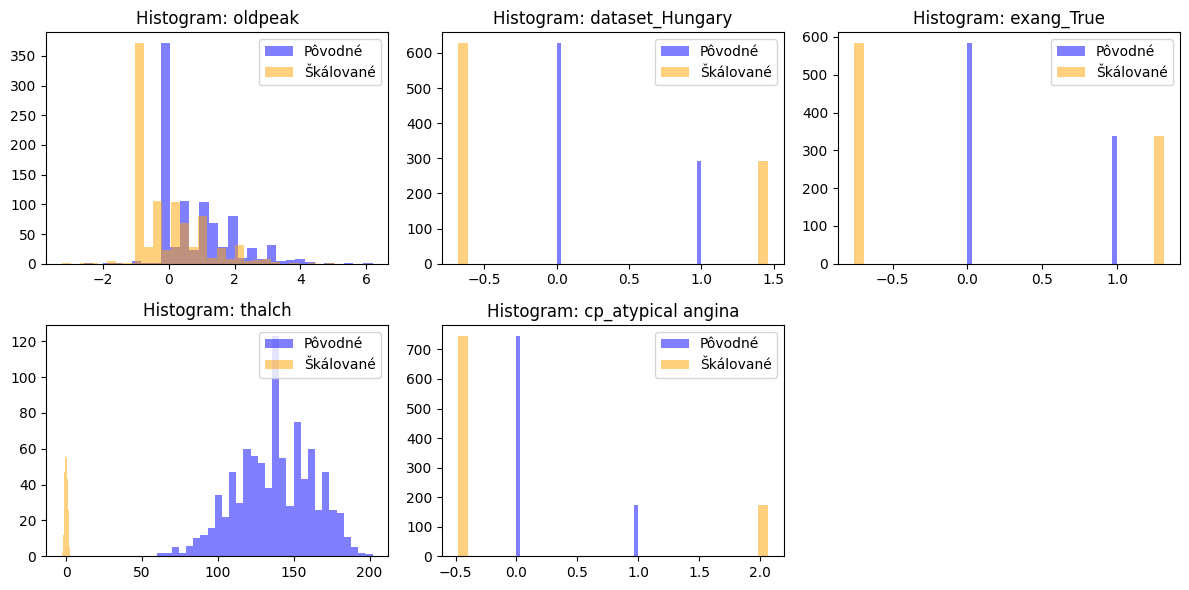

In [ ]:
### 🔹 1️⃣ Histogramy (iba top 5 premenných) ###
plt.figure(figsize=(12, 6))
for i, col in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(X[col], bins=30, alpha=0.5, label='Pôvodné', color='blue')
    plt.hist(X_scaled_df[col], bins=30, alpha=0.5, label='Škálované', color='orange')
    plt.title(f'Histogram: {col}')
    plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-83-9ff1d0e12e61>:5: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[X[col], X_scaled_df[col]], palette=['blue', 'orange'])
<ipython-input-83-9ff1d0e12e61>:5: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[X[col], X_scaled_df[col]], palette=['blue', 'orange'])
<ipython-input-83-9ff1d0e12e61>:5: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[X[col], X_scaled_df[col]], palette=['blue', 'orange'])
<ipython-input-83-9ff1d0e12e61>:5: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[X[col], X_scaled_df[col]], palette=['blue', 'orange'])
<ipython-input-83-9ff1d0e12e61>:5: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[X[col], X_scaled_df[col]], palette=

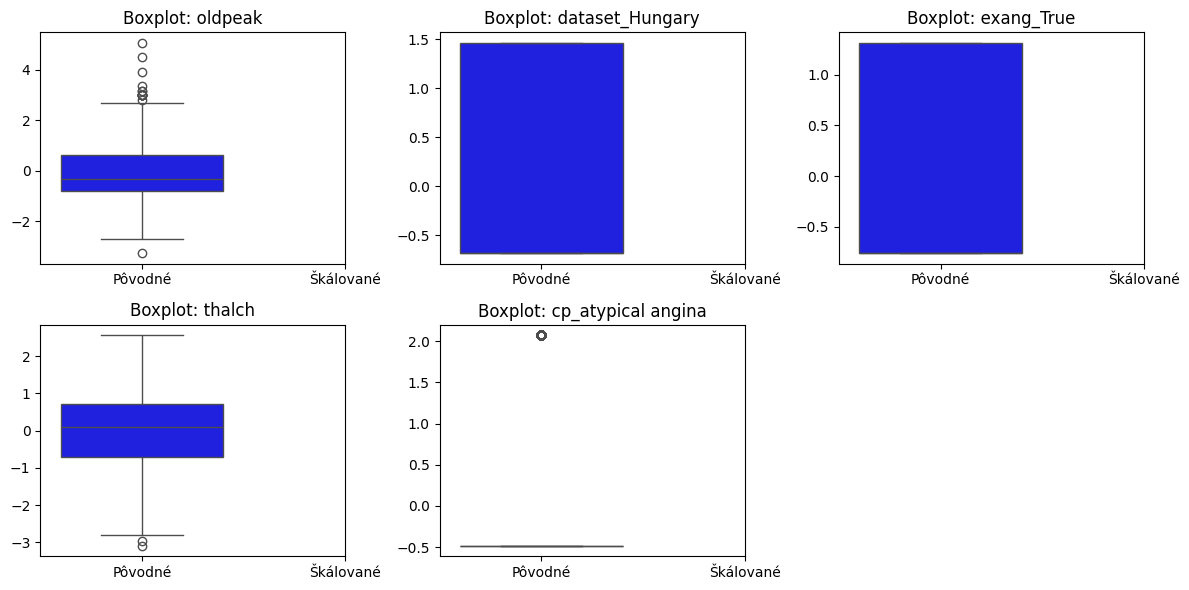

In [ ]:
### 🔹 2️⃣ Boxploty (iba top 5 premenných) ###
plt.figure(figsize=(12, 6))
for i, col in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=[X[col], X_scaled_df[col]], palette=['blue', 'orange'])
    plt.xticks([0, 1], ['Pôvodné', 'Škálované'])
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

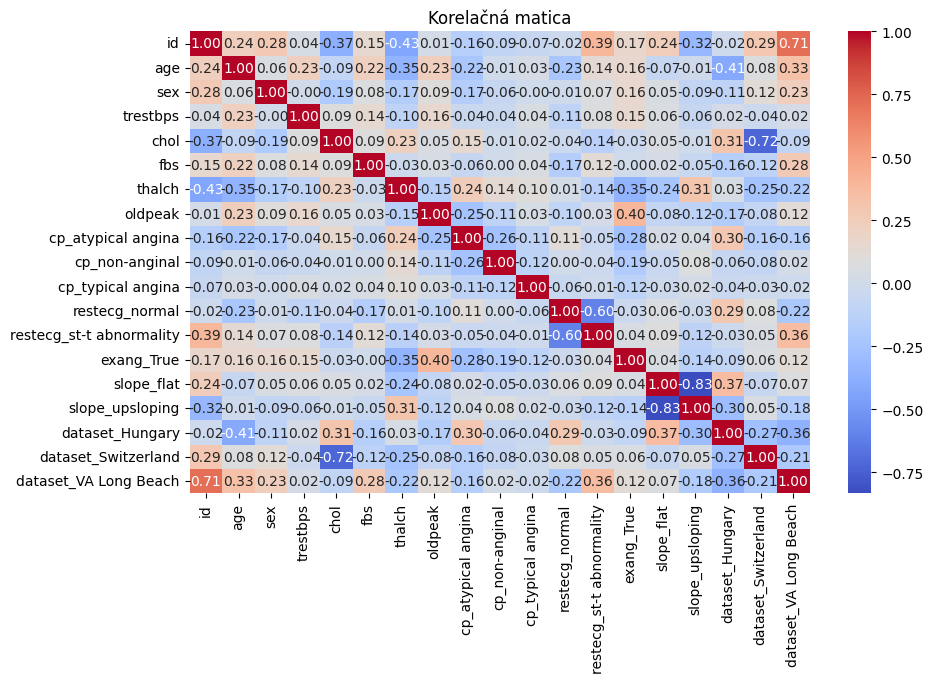

In [ ]:
### 🔹 3️⃣ Korelačná matica (všetky numerické premenné) ###
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelačná matica")
plt.show()

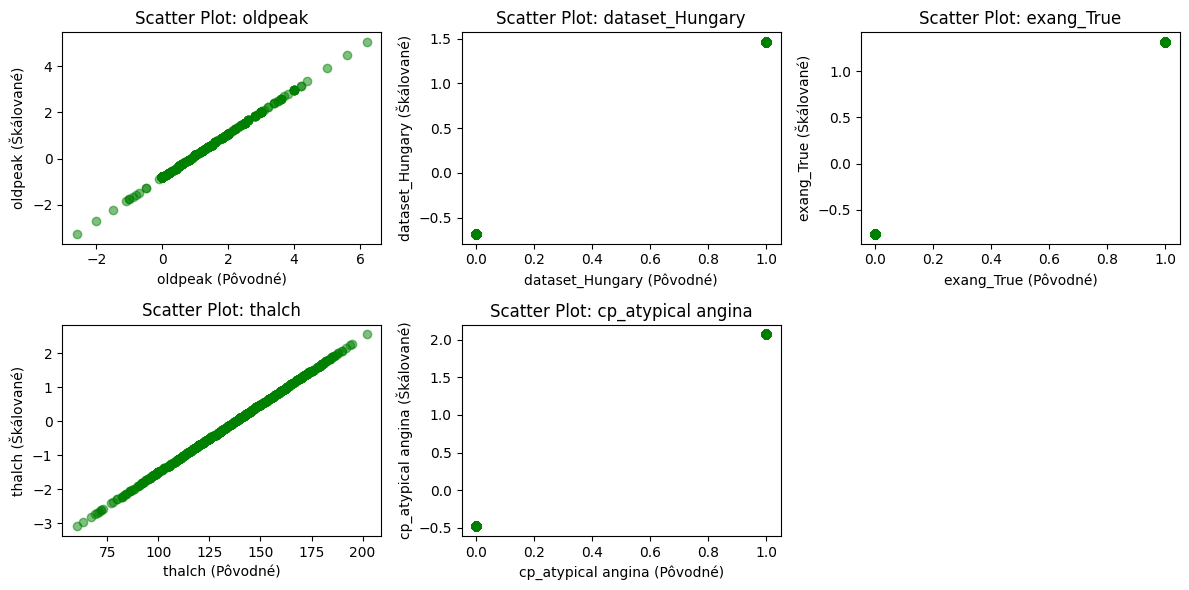

In [ ]:
### 🔹 4️⃣ Scatter ploty (len pre top 5 premenných) ###
plt.figure(figsize=(12, 6))
for i, col in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(X[col], X_scaled_df[col], alpha=0.5, color='green')
    plt.xlabel(f'{col} (Pôvodné)')
    plt.ylabel(f'{col} (Škálované)')
    plt.title(f'Scatter Plot: {col}')

plt.tight_layout()
plt.show()

**Modelovanie - logistická regrresia**

 Krok 1: Príprava dát na modelovanie
Pred samotným tréningom modelu: ✅ Rozdelíme dataset na trénovaciu a testovaciu množinu
✅ Overíme, či cieľová premenná (num) má binárne hodnoty (0 a 1) alebo viac kategórií
✅ Ak je viac kategórií, môžeme previesť na binárnu klasifikáciu (napr. 0 = zdravý, 1 = chorý)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 🔹 1️⃣ Rozdelenie dát
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)




 Krok 2: Tréning logistickej regresie
Použijeme Scikit-Learn na natrénovanie modelu:
✅ Fitneme model na trénovacích dátach
✅ Predikujeme na testovacích dátach
✅ Vyhodnotíme presnosť modelu pomocou metriky accuracy, precision, recall a F1-score

In [ ]:
# 🔹 2️⃣ Tréning logistickej regresie
model = LogisticRegression()
model.fit(X_train, y_train)

# 🔹 3️⃣ Predikcie
y_pred = model.predict(X_test)

# 🔹 4️⃣ Vyhodnotenie modelu
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"✅ Presnosť modelu: {accuracy:.2f}")
print("\n📊 Maticová konfúzia:\n", conf_matrix)
print("\n🔹 Report klasifikácie:\n", report)


✅ Presnosť modelu: 0.55

📊 Maticová konfúzia:
 [[68  6  1  0  0]
 [19 28  2  4  1]
 [ 6 11  2  6  0]
 [ 8 12  2  4  0]
 [ 0  0  3  1  0]]

🔹 Report klasifikácie:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77        75
           1       0.49      0.52      0.50        54
           2       0.20      0.08      0.11        25
           3       0.27      0.15      0.20        26
           4       0.00      0.00      0.00         4

    accuracy                           0.55       184
   macro avg       0.33      0.33      0.32       184
weighted avg       0.48      0.55      0.51       184



**Interpretácia výsledkov modelu**

 Presnosť modelu: 55 % → To znamená, že model správne klasifikoval 55 % prípadov, čo nie je veľmi dobrý výsledok.

Analýza konfúznej matice
Trieda 0 (zdraví pacienti) → Model správne klasifikoval 68 z 75 (91 % recall), čo je dobré.

Trieda 1 → Model správne identifikoval 28 z 54 (52 % recall), čo je priemerné.

Triedy 2, 3, 4 → Model ich klasifikoval veľmi slabo, najmä triedu 4 (0 % recall), čo znamená, že tento model nedokáže dobre rozoznať vážnejšie prípady ochorenia.

Čo znamenajú metriky precision, recall a F1-score?
Precision → Ak model predpovie danú triedu, aká je pravdepodobnosť, že má pravdu?

Napr. pre triedu 0 je 67 %, takže keď model predpovie „zdravý“, v 67 % prípadoch má pravdu.

Recall → Koľko skutočných prípadov danej triedy model správne identifikoval?

Napr. trieda 0 má recall 91 %, takže model dobre identifikuje zdravých pacientov.

F1-score → Vyvážená metrika medzi precision a recall.

Nižšie hodnoty pre triedy 2, 3 a 4 znamenajú, že model ich nedokáže dobre klasifikovať.



**Ako zlepšiť model?**

1.Zmeniť logistickú regresiu na iný model

Random Forest, SVM alebo XGBoost môžu dosiahnuť lepšie výsledky.

2️. Upraviť cieľovú premennú ("num")

Momentálne model predpovedá 5 tried, ale triedy 2, 3 a 4 majú málo dát → môžeme zlúčiť niektoré triedy do binárnej klasifikácie (napr. 0 = zdravý, 1 = chorý).

3. Vyváženie datasetu

Triedy 2, 3 a 4 majú menej vzoriek → môžeme použiť Oversampling (SMOTE) alebo váhovanie tried.

4️. Použiť Feature Selection

*   Položka zoznamu
*   Položka zoznamu

